In [1]:
from __future__ import print_function, unicode_literals, division, absolute_import

import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import time 
from scipy.stats import norm 
from scipy import stats
import random

%matplotlib inline

In [2]:
path = 'data'
df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Heatmap

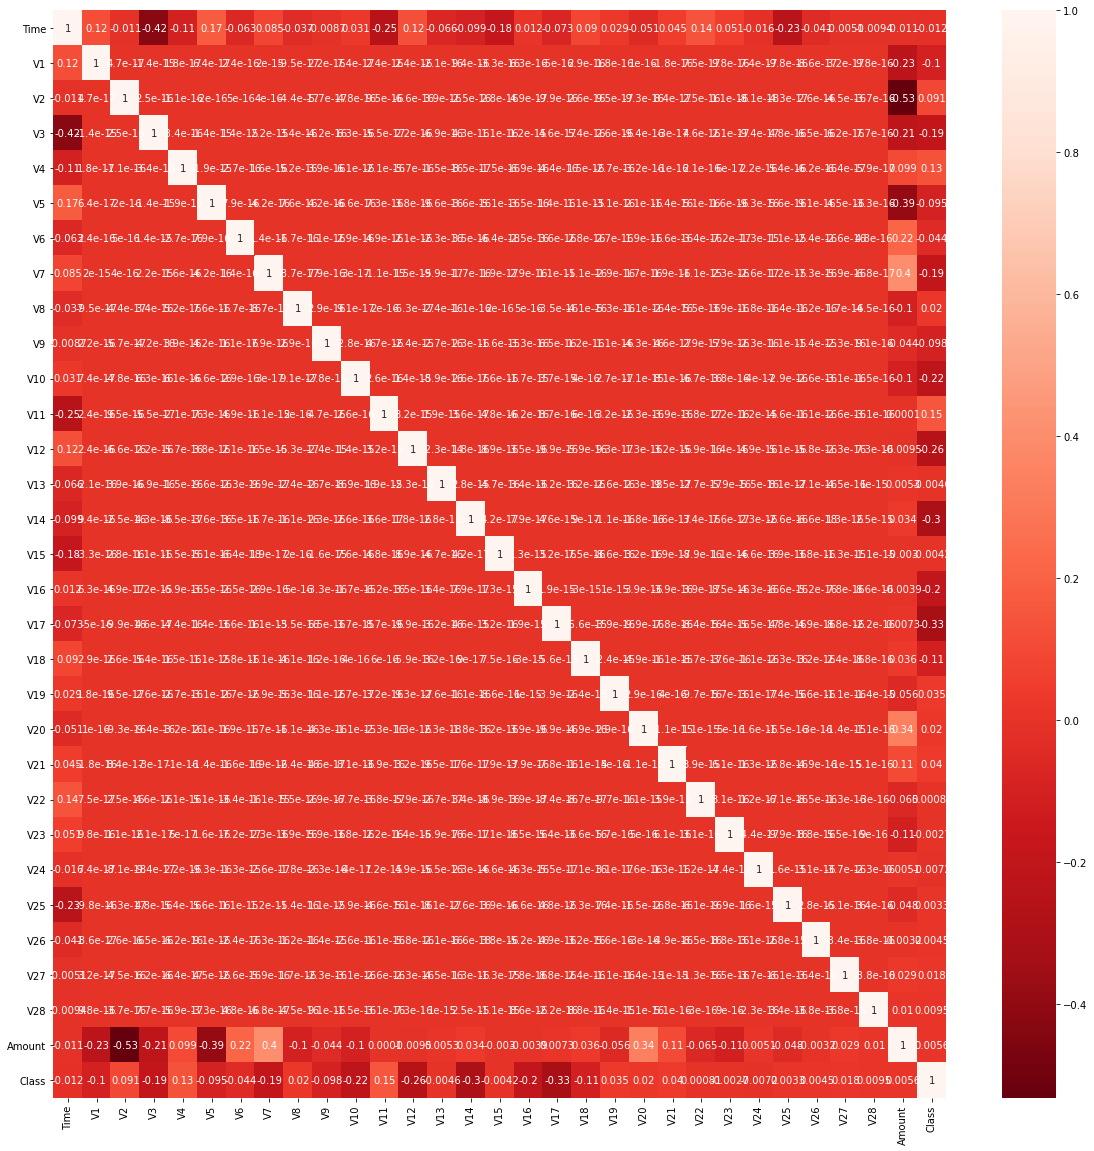

In [3]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds_r)
plt.show()

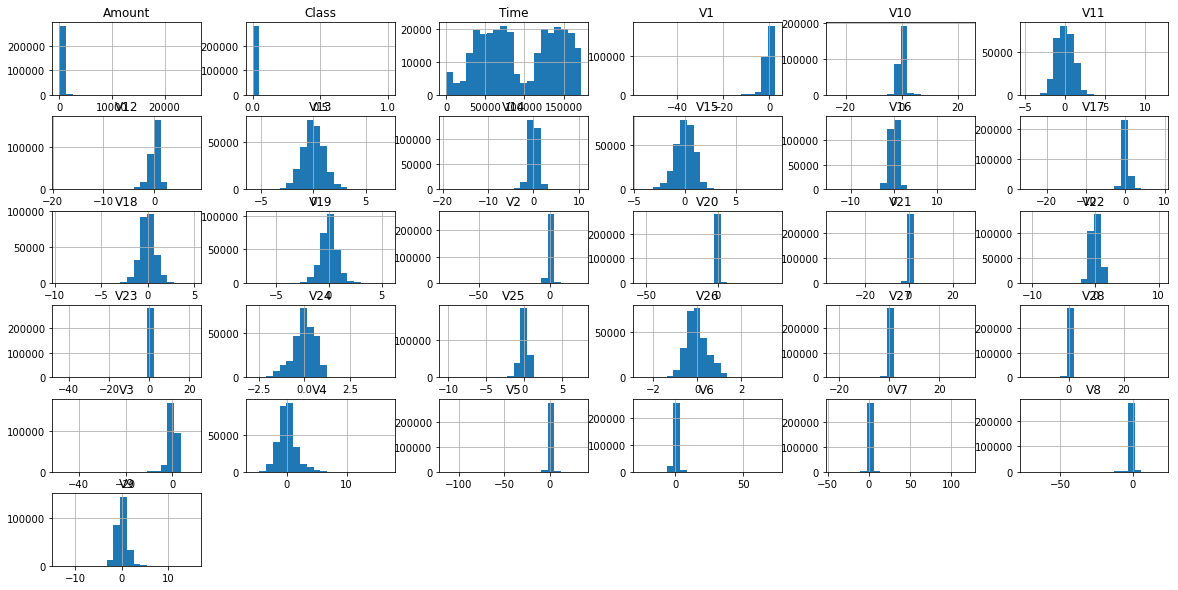

In [4]:
df.hist(bins=20, figsize=(20, 10))
plt.show()

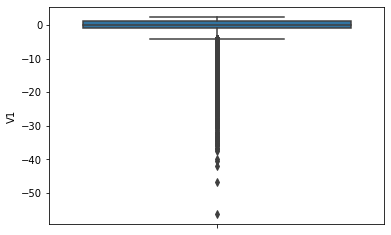

In [5]:
## mendeteksi outlier menggunakan boxplot
## dengan contoh "V1"

sns.boxplot(y=df['V1'])

count    2.848070e+05
mean     3.919560e-15
std      1.958696e+00
min     -5.640751e+01
25%     -9.203734e-01
50%      1.810880e-02
75%      1.315642e+00
max      2.454930e+00
Name: V1, dtype: float64


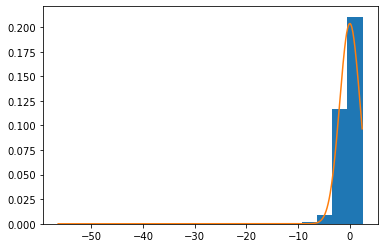

In [6]:
print(df['V1'].describe())

plt.hist(df['V1'], bins=20, density=True)

rng = np.arange(df['V1'].min(), df['V1'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, df['V1'].mean(), df['V1'].std()))


## Hapus Outlier

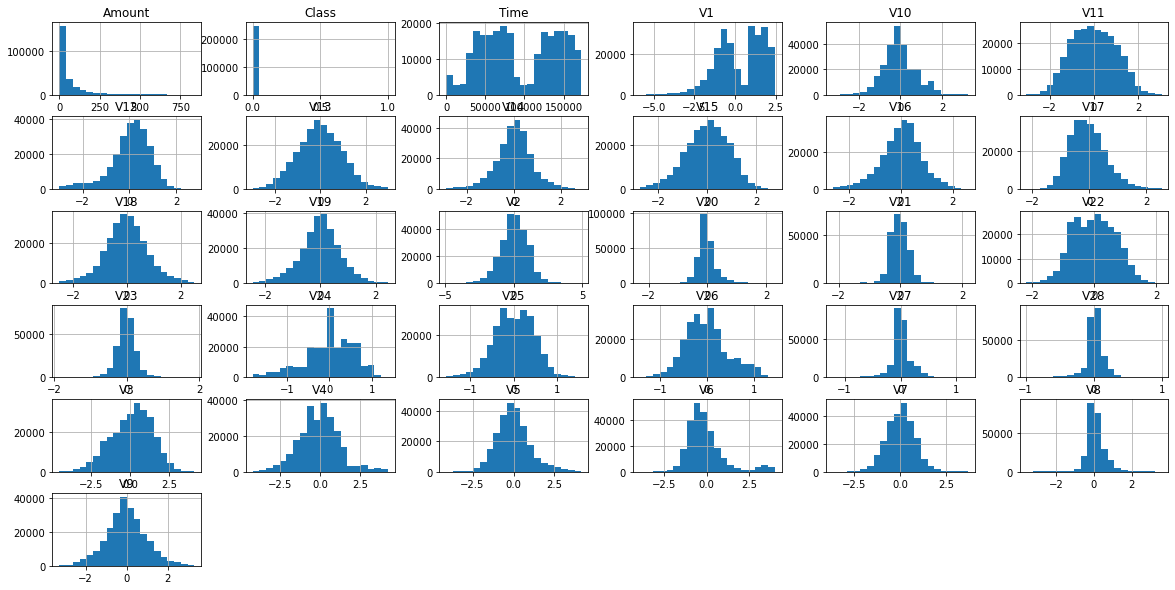

In [7]:
z_score = np.abs(stats.zscore(df.drop(['Time', 'Class'], axis=1)))

df_no_outlier = df[((z_score < 3).all(axis=1)) & ((z_score > -3).all(axis=1))]  # menggunakan std 3
df_no_outlier.hist(bins=20, figsize=(20, 10))
plt.show()

0    246943
1        48
Name: Class, dtype: int64


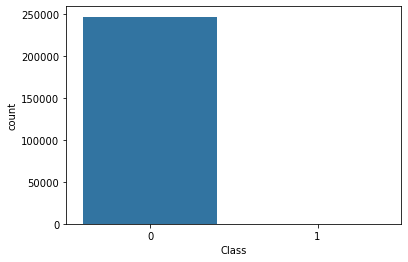

In [8]:
print(df_no_outlier['Class'].value_counts())
sns.countplot(df_no_outlier['Class'])
plt.show()

setelah dilakukan penghapusan outlier, terjadi ketidak seimbangan data. berdasrkan gambar diatas bahwa jumlah class 0 dan 1 mengalami penjomplangan data yang besar. class 0 sebesar 246943 dan class 1 sebesar 48

Pada kasus ini, dilakukan beberapa percobaan yaitu dengan membedakan data secara imbalanced data dan balanced data dan membedakan data dengan pemilihan(seleksi)/fiilter fitur yang dominan dan dengan tanpa metode seleksi fitur

## Import library

In [9]:
import sklearn
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample

## Func feature selection

In [10]:
def feature_selection(X, y, func):
    fs = SelectKBest(score_func=func, k='all')
    fs.fit(X, y)
    select = fs.transform(X)
    
    cols = list(X.columns)

    temp = []
    selected_features = []
    
    for i in range(len(fs.scores_)):
        temp.append(fs.scores_[i])
    
    score_min = np.mean(temp)        
    
    for i in range(len(fs.scores_)):
        if fs.scores_[i] >= score_min:
            print(f'Features Selected {cols[i]} : {fs.scores_[i]}')
            selected_features.append(cols[i])
            
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    
    return selected_features

## Func train split

In [17]:
def train_split(model, X, y, test_size, random_state, scaler = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('No Scaling !!!')
    if scaler:
        print('Scaling')
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("Accuracy train: %.3f%%\tAccuracy test: %.3f%%"%(train_score*100.0, test_score*100.0))
    return train_score, test_score

## Func cross validation

In [19]:
def model_cross_valid(model, X, y, n_split, random_state, imbalanced=False, scaler=False):
    print('No Scaling !!!')
    
    if scaler:
        print('Scaling !!!')
        sc = StandardScaler()
        X = sc.fit_transform(X)
    
    if imbalanced:
        # cv = ShuffleSplit(n_splits=n_split, test_size=test_size, random_state=random_state)
        cv = StratifiedKFold(n_splits=n_split, random_state=random_state)
    else:
        cv = KFold(n_splits=n_split, random_state=random_state)
        
    results = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print('Accuracy : %.3f%% (%.3f%%)' %(np.mean(results)*100, np.std(results)*100))
    
    return np.mean(results), np.std(results)
    

## Model Selection

In [14]:
lr = LogisticRegression()
sgd = SGDClassifier()
l_svc = LinearSVC()
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
r_forest = RandomForestClassifier()

clfs = [lr, sgd, l_svc, tree, knn]

## Work in imbalanced data

In [15]:
df_imbalanced_data = df_no_outlier.copy()

### 1. No Feature Selection

In [16]:
X = df_imbalanced_data.drop(['Time','Class'], axis=1)
y = df_imbalanced_data['Class'].values

#### a. using func train_split

In [18]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    train_score, test_score = train_split(clf, X, y, 0.2, 42, scaler=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start} \n\n")
    scores.append({
        'Model':clf,
        'Train score': train_score,
        'Test score': test_score
    })
    
    results = pd.DataFrame(scores)
    
results.head()
        

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy train: 99.982%	Accuracy test: 99.976%
Times model LogisticRegression() needed is 5.6318089962005615 


Model SGDClassifier()
No Scaling !!!
Accuracy train: 99.982%	Accuracy test: 99.976%
Times model SGDClassifier() needed is 2.217010498046875 


Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy train: 99.982%	Accuracy test: 99.976%
Times model LinearSVC() needed is 89.82534408569336 


Model DecisionTreeClassifier()
No Scaling !!!
Accuracy train: 100.000%	Accuracy test: 99.955%
Times model DecisionTreeClassifier() needed is 22.752726316452026 


Model KNeighborsClassifier()
No Scaling !!!
Accuracy train: 99.982%	Accuracy test: 99.976%
Times model KNeighborsClassifier() needed is 347.18906831741333 




,Model,Train score,Test score
0,LogisticRegression(),0.999818,0.999757
1,SGDClassifier(),0.999818,0.999757
2,LinearSVC(),0.999818,0.999757
3,DecisionTreeClassifier(),1.000000,0.999555
4,KNeighborsClassifier(),0.999818,0.999757


#### b. using Kfold

In [20]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 86.391% (8.991%)
Times model LogisticRegression() needed is 9.349822998046875

Model SGDClassifier()
No Scaling !!!
Accuracy : 70.491% (15.050%)
Times model SGDClassifier() needed is 5.404037714004517

Model LinearSVC()
No Scaling !!!
Accuracy : 74.252% (10.822%)
Times model LinearSVC() needed is 118.99676728248596

Model DecisionTreeClassifier()
No Scaling !!!
Accuracy : 50.614% (1.251%)
Times model DecisionTreeClassifier() needed is 32.72141408920288

Model KNeighborsClassifier()
No Scaling !!!
Accuracy : 49.952% (0.027%)
Times model KNeighborsClassifier() needed is 107.80290126800537



,Model,Mean score,STD score
0,LogisticRegression(),0.863908,0.089909
1,SGDClassifier(),0.704907,0.150496
2,LinearSVC(),0.742520,0.108216
3,DecisionTreeClassifier(),0.506137,0.012506
4,KNeighborsClassifier(),0.499520,0.000274


 Pada percobaan ini model terbaik adalah LogisticRegression

#### c. Using Shuffle Split

In [21]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=True)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 84.927% (9.985%)
Times model LogisticRegression() needed is 8.025954723358154

Model SGDClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 63.783% (8.474%)
Times model SGDClassifier() needed is 3.6881887912750244

Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 74.532% (4.214%)
Times model LinearSVC() needed is 124.38880658149719

Model DecisionTreeClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 50.985% (2.002%)
Times model DecisionTreeClassifier() needed is 33.29438138008118

Model KNeighborsClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 52.164% (2.700%)
Times model KNeighborsClassifier() needed is 108.07609844207764



,Model,Mean score,STD score
0,LogisticRegression(),0.849273,0.099854
1,SGDClassifier(),0.637832,0.084736
2,LinearSVC(),0.745320,0.042139
3,DecisionTreeClassifier(),0.509850,0.020019
4,KNeighborsClassifier(),0.521643,0.026996


Pada percobaan ini model terbaik adalah Logistic Regression

### 2. With Feature Selection

In [22]:
X = df_imbalanced_data.drop(['Time','Class'], axis=1)
y = df_imbalanced_data['Class'].values

Features Selected V4 : 67.35749271958204
Features Selected V7 : 11.260191155967684
Features Selected V8 : 10.642756494109054
Features Selected V14 : 54.409978533577515
Features Selected V17 : 60.21443677312165
Features Selected V18 : 14.256115944854859
Features Selected V19 : 9.86536554621786
Features Selected Amount : 10.174908222893272


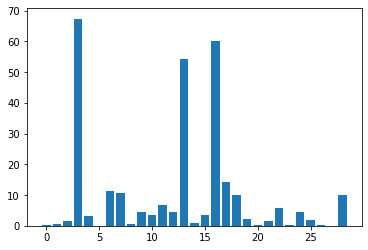

In [23]:
## Finding features
features_selected = feature_selection(X, y, f_classif)

In [24]:
## modified attribute after get features selected

X = df_imbalanced_data[features_selected]
y = df_imbalanced_data['Class'].values

In [25]:
X

,V4,V7,V8,V14,V17,V18,V19,Amount
0,1.378155,0.239599,0.098698,-0.311169,0.207971,0.025791,0.403993,149.62
1,0.448154,-0.078803,0.085102,-0.143772,-0.114805,-0.183361,-0.145783,2.69
3,-0.863291,0.237609,0.377436,-0.287924,-0.684093,1.965775,-1.232622,123.50
4,0.403034,0.592941,-0.270533,-1.119670,-0.237033,-0.038195,0.803487,69.99
5,-0.168252,0.476201,0.260314,-0.137134,-0.058133,0.068653,-0.033194,3.67
...,...,...,...,...,...,...,...,...
284800,0.234580,0.017050,-0.118228,0.626211,-0.605252,-0.163049,0.561695,2.68
284801,-0.745097,0.812722,0.115093,-0.731707,0.070441,0.373110,0.128904,2.69
284803,-0.738589,0.024330,0.294869,-0.675143,-0.025693,-1.221179,-1.545556,24.79
284804,-0.557828,-0.296827,0.708417,-0.510602,0.313502,0.395652,-0.577252,67.88


#### a. using func train_split

In [26]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    train_score, test_score = train_split(clf, X, y, 0.2, 42, scaler=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start} \n\n")
    scores.append({
        'Model':clf,
        'Train score': train_score,
        'Test score': test_score
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!
Accuracy train: 99.982%	Accuracy test: 99.976%
Times model LogisticRegression() needed is 4.217872858047485 


Model SGDClassifier()
No Scaling !!!
Accuracy train: 99.982%	Accuracy test: 99.976%
Times model SGDClassifier() needed is 1.1740832328796387 


Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy train: 99.982%	Accuracy test: 99.976%
Times model LinearSVC() needed is 44.95137357711792 


Model DecisionTreeClassifier()
No Scaling !!!
Accuracy train: 100.000%	Accuracy test: 99.957%
Times model DecisionTreeClassifier() needed is 4.9400365352630615 


Model KNeighborsClassifier()
No Scaling !!!
Accuracy train: 99.983%	Accuracy test: 99.976%
Times model KNeighborsClassifier() needed is 50.16643953323364 




,Model,Train score,Test score
0,LogisticRegression(),0.999818,0.999757
1,SGDClassifier(),0.999818,0.999757
2,LinearSVC(),0.999818,0.999757
3,DecisionTreeClassifier(),1.000000,0.999575
4,KNeighborsClassifier(),0.999828,0.999757


#### b. using Kfold

In [27]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 88.843% (4.335%)
Times model LogisticRegression() needed is 6.245632886886597

Model SGDClassifier()
No Scaling !!!
Accuracy : 61.881% (11.915%)
Times model SGDClassifier() needed is 3.565716028213501

Model LinearSVC()
No Scaling !!!
Accuracy : 75.462% (4.399%)
Times model LinearSVC() needed is 72.74633932113647

Model DecisionTreeClassifier()
No Scaling !!!
Accuracy : 49.988% (0.007%)
Times model DecisionTreeClassifier() needed is 6.6316070556640625

Model KNeighborsClassifier()
No Scaling !!!
Accuracy : 50.585% (1.258%)
Times model KNeighborsClassifier() needed is 14.521904468536377



,Model,Mean score,STD score
0,LogisticRegression(),0.888427,0.043352
1,SGDClassifier(),0.618807,0.119150
2,LinearSVC(),0.754615,0.043985
3,DecisionTreeClassifier(),0.499881,0.000070
4,KNeighborsClassifier(),0.505853,0.012577


#### c. Using Shuffle Split

In [28]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=True)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 87.826% (4.560%)
Times model LogisticRegression() needed is 5.589820623397827

Model SGDClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 66.136% (11.861%)
Times model SGDClassifier() needed is 2.7144436836242676

Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 73.311% (11.982%)
Times model LinearSVC() needed is 72.14659571647644

Model DecisionTreeClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 49.982% (0.013%)
Times model DecisionTreeClassifier() needed is 7.1936986446380615

Model KNeighborsClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 53.290% (4.444%)
Times model KNeighborsClassifier() needed is 14.38069200515747



,Model,Mean score,STD score
0,LogisticRegression(),0.878258,0.045598
1,SGDClassifier(),0.661364,0.118614
2,LinearSVC(),0.733114,0.119818
3,DecisionTreeClassifier(),0.499824,0.000128
4,KNeighborsClassifier(),0.532903,0.044439


## Work Balanced data

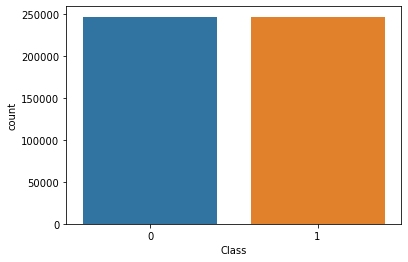

1    246943
0    246943
Name: Class, dtype: int64


In [29]:
## Balanced data using resample

df_temp = df_no_outlier.copy()

not_fraud = df_temp[df_temp['Class']==0]
fraud = df_temp[df_temp['Class']==1]

fraud_resampled = resample(fraud, replace=True, n_samples=len(not_fraud),
                          random_state=42)
df_balanced_data = pd.concat([not_fraud, fraud_resampled])
df_balanced_data = df_balanced_data.sample(frac=1)

sns.countplot(df_balanced_data['Class'])
plt.show()
print(df_balanced_data['Class'].value_counts())

### 1. No Feature Selection

In [31]:
X = df_balanced_data.drop(['Time','Class'], axis=1)
y = df_balanced_data['Class'].values

#### a. using func train_split

In [32]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    train_score, test_score = train_split(clf, X, y, 0.2, 42, scaler=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start} \n\n")
    scores.append({
        'Model':clf,
        'Train score': train_score,
        'Test score': test_score
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy train: 87.686%	Accuracy test: 87.680%
Times model LogisticRegression() needed is 8.963784456253052 


Model SGDClassifier()
No Scaling !!!
Accuracy train: 86.414%	Accuracy test: 86.463%
Times model SGDClassifier() needed is 48.32070851325989 


Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy train: 73.374%	Accuracy test: 73.234%
Times model LinearSVC() needed is 244.02260780334473 


Model DecisionTreeClassifier()
No Scaling !!!
Accuracy train: 100.000%	Accuracy test: 99.985%
Times model DecisionTreeClassifier() needed is 19.79703950881958 


Model KNeighborsClassifier()
No Scaling !!!
Accuracy train: 99.986%	Accuracy test: 99.977%
Times model KNeighborsClassifier() needed is 660.7008304595947 




,Model,Train score,Test score
0,LogisticRegression(),0.876864,0.876805
1,SGDClassifier(),0.864143,0.864626
2,LinearSVC(),0.733744,0.732339
3,DecisionTreeClassifier(),1.000000,0.999848
4,KNeighborsClassifier(),0.999858,0.999767


#### b. using Kfold

In [33]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 93.135% (0.193%)
Times model LogisticRegression() needed is 15.35471248626709

Model SGDClassifier()
No Scaling !!!
Accuracy : 92.940% (0.730%)
Times model SGDClassifier() needed is 62.7983193397522

Model LinearSVC()
No Scaling !!!
Accuracy : 89.608% (0.760%)
Times model LinearSVC() needed is 2188.7433314323425

Model DecisionTreeClassifier()
No Scaling !!!
Accuracy : 99.990% (0.001%)
Times model DecisionTreeClassifier() needed is 25.7846622467041

Model KNeighborsClassifier()
No Scaling !!!
Accuracy : 99.993% (0.002%)
Times model KNeighborsClassifier() needed is 130.13588118553162



,Model,Mean score,STD score
0,LogisticRegression(),0.931351,0.001935
1,SGDClassifier(),0.929397,0.007300
2,LinearSVC(),0.896078,0.007602
3,DecisionTreeClassifier(),0.999897,0.000008
4,KNeighborsClassifier(),0.999927,0.000024


#### c. Using Shuffle Split

In [34]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=True)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 93.058% (0.229%)
Times model LogisticRegression() needed is 12.036538124084473

Model SGDClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.781% (6.185%)
Times model SGDClassifier() needed is 49.836458921432495

Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 79.251% (6.955%)
Times model LinearSVC() needed is 329.76363611221313

Model DecisionTreeClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 99.988% (0.002%)
Times model DecisionTreeClassifier() needed is 35.09681057929993

Model KNeighborsClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 99.993% (0.002%)
Times model KNeighborsClassifier() needed is 178.34574580192566



,Model,Mean score,STD score
0,LogisticRegression(),0.930578,0.002289
1,SGDClassifier(),0.897813,0.061847
2,LinearSVC(),0.792510,0.069551
3,DecisionTreeClassifier(),0.999883,0.000024
4,KNeighborsClassifier(),0.999927,0.000023


### 2. With Feature Selection

Features Selected V4 : 149945.0650510353
Features Selected V7 : 24233.503641504292
Features Selected V8 : 28344.110756040882
Features Selected V14 : 93068.32927722816
Features Selected V17 : 105348.0001118564
Features Selected V18 : 46122.70711866196


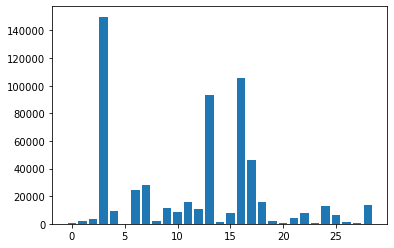

In [36]:
## Finding features
X = df_balanced_data.drop(['Time','Class'], axis=1)
y = df_balanced_data['Class'].values
features_selected = feature_selection(X, y, f_classif)
## modified attribute after get features selected

X = df_balanced_data[features_selected]
y = df_balanced_data['Class'].values

In [37]:
X

,V4,V7,V8,V14,V17,V18
93486,2.755369,-0.042848,0.246625,-1.633472,1.593529,1.178468
145800,2.786750,1.600027,-0.117427,-0.429212,1.679986,1.315339
214775,-0.203459,-0.076548,-0.992260,1.065262,-0.223768,0.768370
9991,2.943149,-0.527593,0.021167,0.850777,0.266961,-0.028494
68067,0.847753,1.448868,0.023308,0.578869,-0.119204,0.826814
...,...,...,...,...,...,...
153535,0.843921,1.645614,-0.710786,1.584221,0.491166,-0.270864
50537,-1.255593,0.059110,-0.003153,-0.499350,-0.207707,0.380542
4145,-0.662129,-0.791182,0.045097,1.590822,0.884261,-1.083580
42567,-0.712916,0.761594,-0.244946,-0.725447,-0.720362,-0.673849


#### a. using func train_split

In [38]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    train_score, test_score = train_split(clf, X, y, 0.2, 42, scaler=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start} \n\n")
    scores.append({
        'Model':clf,
        'Train score': train_score,
        'Test score': test_score
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!
Accuracy train: 81.479%	Accuracy test: 81.561%
Times model LogisticRegression() needed is 0.7953472137451172 


Model SGDClassifier()
No Scaling !!!
Accuracy train: 83.814%	Accuracy test: 83.822%
Times model SGDClassifier() needed is 0.9755268096923828 


Model LinearSVC()
No Scaling !!!
Accuracy train: 81.597%	Accuracy test: 81.661%
Times model LinearSVC() needed is 59.650803565979004 


Model DecisionTreeClassifier()
No Scaling !!!
Accuracy train: 100.000%	Accuracy test: 99.991%
Times model DecisionTreeClassifier() needed is 2.036733865737915 


Model KNeighborsClassifier()
No Scaling !!!
Accuracy train: 99.983%	Accuracy test: 99.975%
Times model KNeighborsClassifier() needed is 104.45200943946838 




,Model,Train score,Test score
0,LogisticRegression(),0.814790,0.815607
1,SGDClassifier(),0.838143,0.838223
2,LinearSVC(),0.815974,0.816609
3,DecisionTreeClassifier(),1.000000,0.999909
4,KNeighborsClassifier(),0.999830,0.999747


#### b. using Kfold

In [39]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=False)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.985% (0.093%)
Times model LogisticRegression() needed is 5.2320146560668945

Model SGDClassifier()
No Scaling !!!
Accuracy : 89.559% (0.113%)
Times model SGDClassifier() needed is 4.03235650062561

Model LinearSVC()
No Scaling !!!
Accuracy : 89.956% (0.093%)
Times model LinearSVC() needed is 110.47780394554138

Model DecisionTreeClassifier()
No Scaling !!!
Accuracy : 99.990% (0.002%)
Times model DecisionTreeClassifier() needed is 7.289883136749268

Model KNeighborsClassifier()
No Scaling !!!
Accuracy : 99.991% (0.003%)
Times model KNeighborsClassifier() needed is 44.20583987236023



,Model,Mean score,STD score
0,LogisticRegression(),0.899852,0.000928
1,SGDClassifier(),0.895592,0.001127
2,LinearSVC(),0.899561,0.000929
3,DecisionTreeClassifier(),0.999899,0.000022
4,KNeighborsClassifier(),0.999907,0.000029


#### c. Using Shuffle Split

In [40]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=True)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.985% (0.094%)
Times model LogisticRegression() needed is 2.1628246307373047

Model SGDClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.680% (0.118%)
Times model SGDClassifier() needed is 2.1125588417053223

Model LinearSVC()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.956% (0.095%)
Times model LinearSVC() needed is 116.65976333618164

Model DecisionTreeClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 99.990% (0.002%)
Times model DecisionTreeClassifier() needed is 5.380005598068237

Model KNeighborsClassifier()
No Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 99.991% (0.003%)
Times model KNeighborsClassifier() needed is 48.834126710891724



,Model,Mean score,STD score
0,LogisticRegression(),0.899854,0.000945
1,SGDClassifier(),0.896804,0.001176
2,LinearSVC(),0.899560,0.000945
3,DecisionTreeClassifier(),0.999899,0.000020
4,KNeighborsClassifier(),0.999907,0.000029


Dari semua percobaan dari menggunakan data yang imbalance data dan balance data, juga menggnakan feature selection atau tidak didapatkan algoritma yang tepat untuk kasus ini yaitu Logistic Regression

In [41]:
scores = []
for clf in clfs:
    print(f'Model {clf}')
    start = time.time()
    mean, std = model_cross_valid(clf, X, y, 5, 42, imbalanced=True, scaler=True)
    end = time.time()
    print(f"Times model {clf} needed is {end-start}\n")
    scores.append({
        'Model':clf,
        'Mean score': mean,
        'STD score': std
    })
    
    results = pd.DataFrame(scores)
    
results.head()

Model LogisticRegression()
No Scaling !!!
Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.985% (0.094%)
Times model LogisticRegression() needed is 4.205393075942993

Model SGDClassifier()
No Scaling !!!
Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.687% (0.138%)
Times model SGDClassifier() needed is 3.4286081790924072

Model LinearSVC()
No Scaling !!!
Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 89.956% (0.095%)
Times model LinearSVC() needed is 167.85630798339844

Model DecisionTreeClassifier()
No Scaling !!!
Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 99.991% (0.002%)
Times model DecisionTreeClassifier() needed is 5.705568790435791

Model KNeighborsClassifier()
No Scaling !!!
Scaling !!!


C:\Users\acer\Anaconda3\envs\python\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy : 99.990% (0.002%)
Times model KNeighborsClassifier() needed is 45.155160665512085



,Model,Mean score,STD score
0,LogisticRegression(),0.899854,0.000944
1,SGDClassifier(),0.896867,0.001384
2,LinearSVC(),0.899560,0.000945
3,DecisionTreeClassifier(),0.999907,0.000020
4,KNeighborsClassifier(),0.999905,0.000024
